# PMS probes and Nevzorov
The following example presents the data collected by the PMS and Nevzorov probes on Polar 5 during the MOSAiC-ACA campaign. The PMS probes where attached to the wings of the aircraft and operated by the group at DLR e.V. and JGU Mainz namely: C. Voigt, M. Moser, and V. Hahn. If you have questions or if you would like to use the data for a publication, please get in contact with the dataset authors as stated above and in the dataset attributes `contact` or `author`.

## Data access
To analyse the data they first have to be loaded by importing the (AC)³ airborne meta data catalogue. To do so the ac3airborne package has to be installed. More information on how to do that and about the catalog can be found [here](https://github.com/igmk/ac3airborne-intake#ac3airborne-intake-catalogue).

Some of the data is stored on the (AC)3 nextcloud server. This requires username and password as credentials (registration) that need to be loaded from environment variables

In [1]:
import os
ac3cloud_username = os.environ['AC3_USER']
ac3cloud_password = os.environ['AC3_PASSWORD']

In [2]:
import ac3airborne
cat = ac3airborne.get_intake_catalog()

### Nevzorov

First, we load the data collected by the Nevzorov.

In [3]:
datasets = []
for campaign in ['MOSAiC-ACA']:
    datasets.extend(list(cat[campaign]['P5']['NEVZOROV']))
datasets

['MOSAiC-ACA_P5_RF03',
 'MOSAiC-ACA_P5_RF05',
 'MOSAiC-ACA_P5_RF06',
 'MOSAiC-ACA_P5_RF07',
 'MOSAiC-ACA_P5_RF08',
 'MOSAiC-ACA_P5_RF09',
 'MOSAiC-ACA_P5_RF10',
 'MOSAiC-ACA_P5_RF11']

```{note}
Have a look at the attributes of the xarray dataset `ds_nevzorov` for all relevant information on the dataset, such as author, contact, or citation information.
```

In [4]:
flight_id = 'MOSAiC-ACA_P5_RF11' # id of flight we work on
ds_nevzorov = cat['MOSAiC-ACA']['P5']['NEVZOROV'][flight_id](user=ac3cloud_username,password=ac3cloud_password).to_dask()
ds_nevzorov

Invalid MIT-MAGIC-COOKIE-1 key

<xarray.Dataset>
Dimensions:        (time: 20801)
Coordinates:
  * time           (time) datetime64[ns] 2020-09-13T09:20:14 ... 2020-09-13T1...
Data variables:
    twc            (time) float64 ...
    lwc            (time) float64 ...
    twc_corrected  (time) float64 ...
    lwc_corrected  (time) float64 ...
Attributes: (12/14)
    version:      0.1
    contact:      christiane.voigt@dlr.de, manuel.moser@dlr.de, valerian.hahn...
    institution:  DLR e.V., JGU Mainz
    author:       Prof. Dr. Christiane Voigt, Manuel Moser, Valerian Hahn, Jo...
    Convention:   CF-1.8
    featureType:  trajectory
    ...           ...
    instruments:  Nevzorov probe
    mission:      MOSAiC-ACA
    platform:     AWI-Polar 5, BT-67 C-GAWI
    uncertainty:  contact PI
    flight_id:    RF11
    history:      acquired by Polar 5 during MOSAiC-ACA campaign and quality ...

The dataset includes the liquid water content (`lwc`) and total water content (`twc`).

### PMS
Next, we load the data from the different instruments of the PMS to determine total number concentration, particle size distributions and water contents.

- Cloud Droplet Probe (CDP) with 2 to 50 microns
- Cloud Imaging Probe (CIP) with 7.5 to 967.5 microns
- Precipitation Imaging Probe (PIP) with 51.5 to 6643.5 microns

In [5]:
ds_cdp = cat['MOSAiC-ACA']['P5']['CDP'][flight_id](user=ac3cloud_username,password=ac3cloud_password).to_dask()
ds_cip = cat['MOSAiC-ACA']['P5']['CIP'][flight_id](user=ac3cloud_username,password=ac3cloud_password).to_dask()
ds_pip = cat['MOSAiC-ACA']['P5']['PIP'][flight_id](user=ac3cloud_username,password=ac3cloud_password).to_dask()

In [6]:
ds_pms_combined = cat['MOSAiC-ACA']['P5']['PMS_COMBINED'][flight_id](user=ac3cloud_username,password=ac3cloud_password).to_dask()
ds_pms_combined

<xarray.Dataset>
Dimensions:    (bins: 93, time: 20132)
Coordinates:
  * time       (time) datetime64[ns] 2020-09-13T09:20:01 ... 2020-09-13T14:59:12
  * bins       (bins) int32 1 2 3 4 5 6 7 8 9 10 ... 85 86 87 88 89 90 91 92 93
Data variables:
    bin_min    (bins) float64 ...
    bin_max    (bins) float64 ...
    bin_mid    (bins) float64 ...
    bin_width  (bins) float64 ...
    N          (time) float64 ...
    CWC        (time) float64 ...
    ED         (time) float64 ...
    MVD        (time) float64 ...
    dNdD       (time, bins) float64 ...
Attributes: (12/14)
    version:      0.1
    contact:      christiane.voigt@dlr.de, manuel.moser@dlr.de, valerian.hahn...
    institution:  DLR e.V., JGU Mainz
    author:       Prof. Dr. Christiane Voigt, Manuel Moser, Valerian Hahn
    Convention:   CF-1.8
    featureType:  trajectory
    ...           ...
    instruments:  CDP, CIP, PIP - combined
    mission:      MOSAiC-ACA
    platform:     AWI-Polar 5, BT-67 C-GAWI
    uncertainty:  contact PI
    flight_id:    RF11
    history:      acquired by Polar 5 during MOSAiC-ACA campaign and quality ...

The dataset `ds_pms_combined` combines the measurements from the different instruments of the PMS and hence includes
total number concentration (`N`),
median volume diameter (`MVD`), liquid water content (`LWC`), ice water content (`IWC`) and particle number concentration (`dNdD`).

## Load Polar 5 flight phase information
Polar 5 flights are divided into segments to easily access start and end times of flight patterns. For more information have a look at the respective [github](https://github.com/igmk/flight-phase-separation) repository.

At first we want to load the flight segments of (AC)³airborne

In [7]:
meta = ac3airborne.get_flight_segments()
flight = meta['MOSAiC-ACA']['P5'][flight_id]

Here, we want to have a look on the size distributions measured during different legs of a `racetrack_pattern`. In order to simplify things we can import the module `flightphase` from the `ac3airborne.tools`.

In [8]:
from ac3airborne.tools import flightphase

We can now select only the `racetrack_pattern`. This kind of pattern is available two times.

In [9]:
flight_query = flightphase.FlightPhaseFile(flight)
queried = flight_query.selectKind(['racetrack_pattern'])
len(queried)

/home/mech/.local/lib/python3.8/site-packages/ac3airborne/tools/flightphase.py:27: UserWarning: the segment MOSAiC-ACA_P5_RF11_rt01 contains following irregularities: first leg begins far away from starting point of the other legs and is therefore longer
  warnings.warn(str)


2

## Plots

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use("../mplstyle/book")

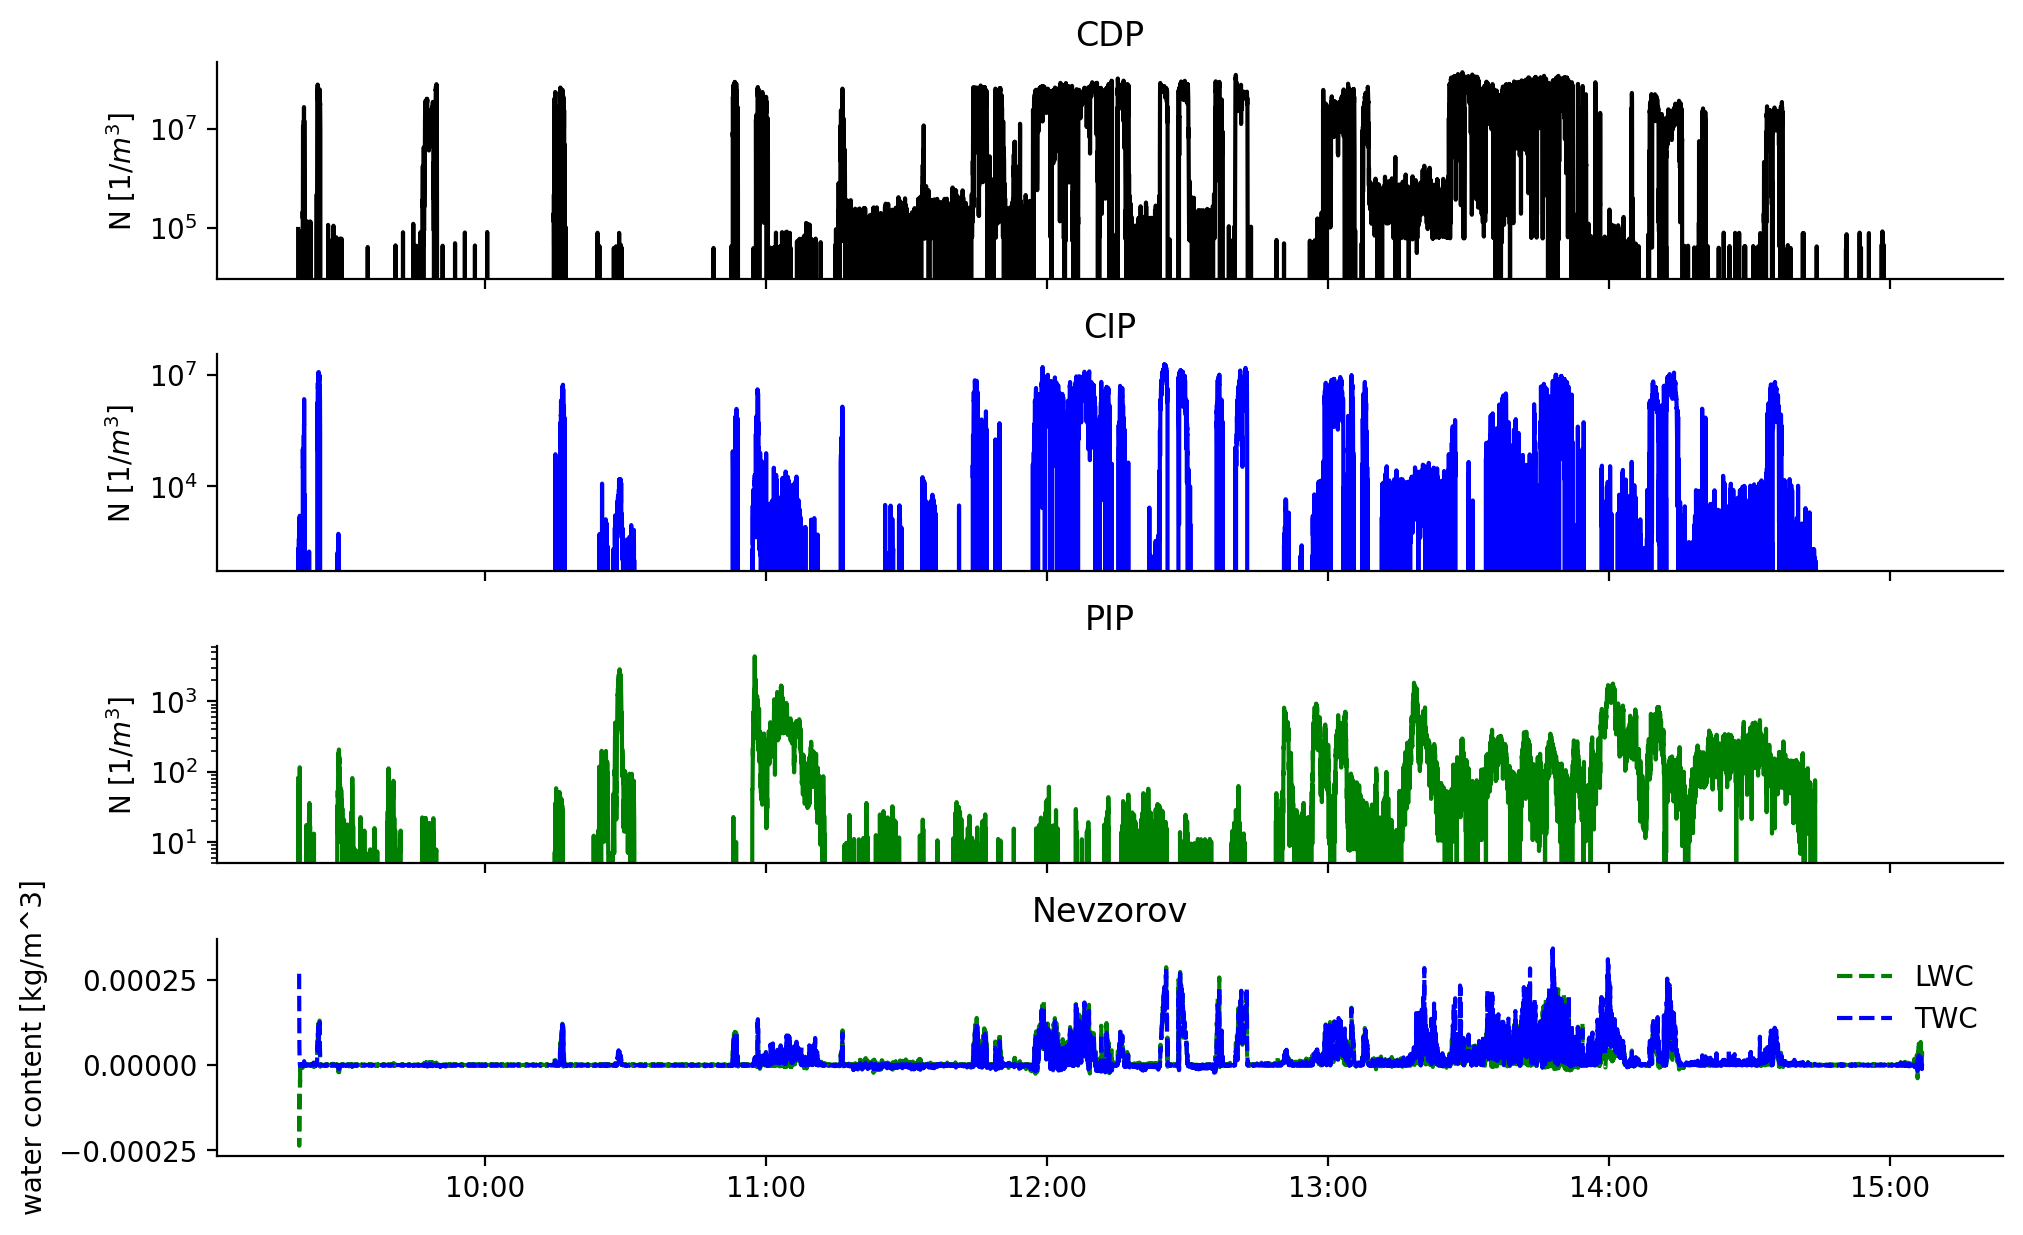

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, gridspec_kw=dict(height_ratios=(1, 1, 1, 1)))
ax1.semilogy(ds_cdp.time, ds_cdp.N, color='k')
ax1.set_title('CDP')
ax2.semilogy(ds_cip.time, ds_cip.N, color='b')
ax2.set_title('CIP')
ax3.semilogy(ds_pip.time, ds_pip.N, color='g')
ax3.set_title('PIP')
ax4.plot(ds_nevzorov.time, ds_nevzorov.lwc, '--', color='g', label='LWC')
ax4.plot(ds_nevzorov.time, ds_nevzorov.twc, '--', color='b', label='TWC')
ax4.set_title('Nevzorov')

ax1.set_ylabel('N [$1/m^3$]')
ax2.set_ylabel('N [$1/m^3$]')
ax3.set_ylabel('N [$1/m^3$]')

ax4.set_ylabel('water content [kg/m^3]')

ax4.legend(frameon=False, loc='upper right')

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

In [12]:
from matplotlib import cm
import numpy as np
def colors(n):
    """Creates set of random colors of length n"""
    
    cmap = cm.get_cmap('gist_rainbow')
    rnd = np.random.uniform(low=0, high=1, size=n)
    cols = cmap(rnd)
    
    return cols

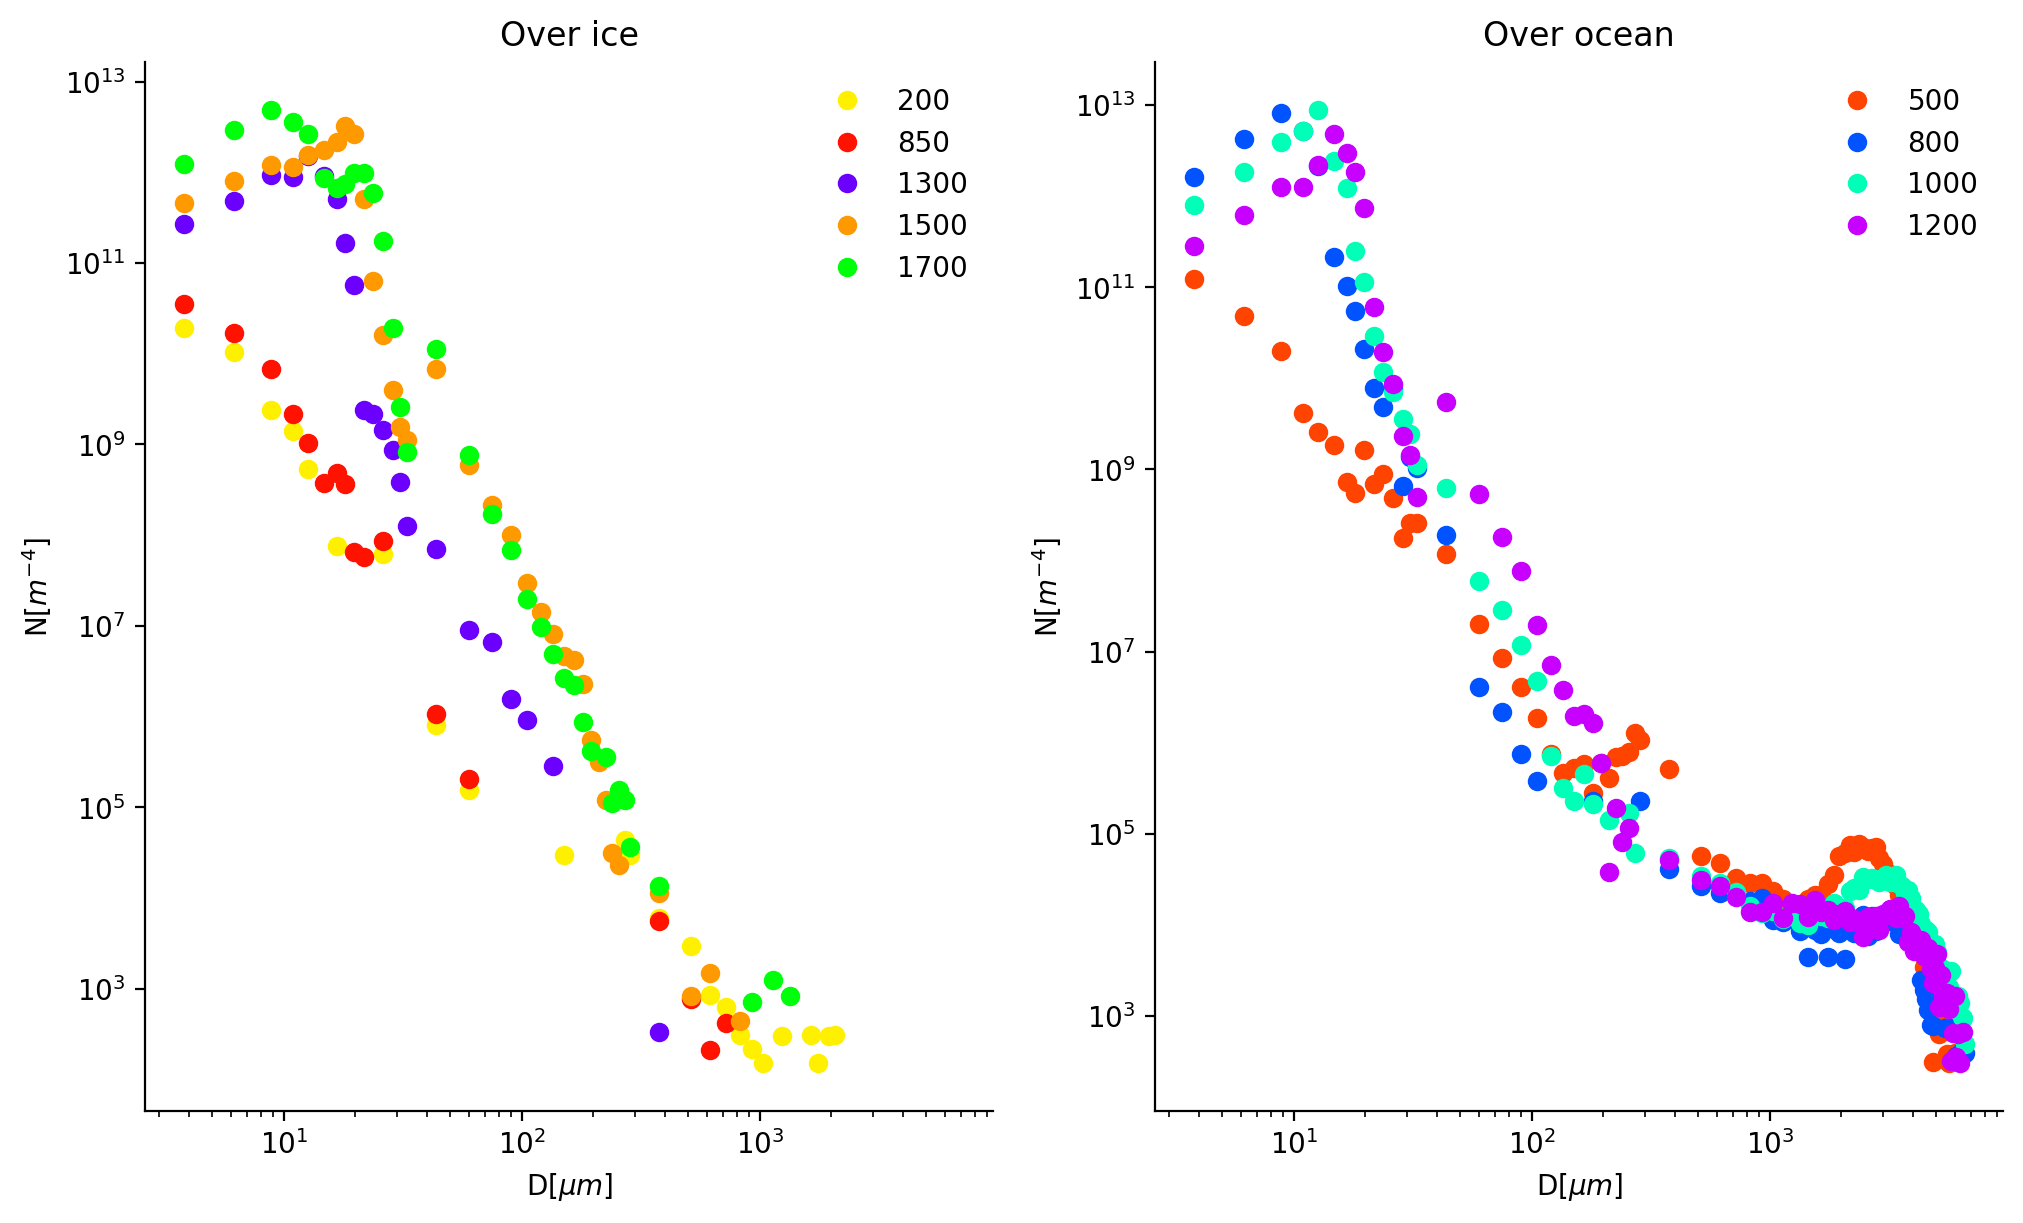

In [13]:
titles = ['ice','ocean']
fig, axs = plt.subplots(1, 2, gridspec_kw=dict())
for i, rtp in enumerate(queried):
    col_segments = colors(len(rtp['parts']))
    for j,part in enumerate(rtp['parts']):
        if 'leg' in part['name']:
            ds_sel = ds_pms_combined.sel(time=slice(part['start'],part['end']))
            axs[i].loglog(ds_sel.bin_mid, ds_sel.dNdD.mean(dim='time'), 'o',color=col_segments[j],label=part['levels'][0])
    axs[i].legend(frameon=False)
    axs[i].set_xlabel('D[$\mu m$]')
    axs[i].set_ylabel('N[$m^{-4}$]')
    axs[i].set_title('Over '+titles[i])